In [19]:
import numpy as np
import plotly as pl
import pandas as pd
import plotly.express as px
from collections import Counter
import warnings
warnings.filterwarnings("ignore")


# Statistikk over rovbase

In [23]:
df = pd.read_csv('../data/rovbase/rovviltskader.csv')
df['year'] = pd.to_datetime(df['Skadedato_fra']).dt.year

df = df.astype({"year": str}) # må konvertere til string for at de skal vises seperatat på kartet

fig = px.scatter_mapbox(df, lat='latitude', lon='longitude', color='year', opacity=0.8, width=800, height=500,
                        zoom=6, title='Rovviltskader Meråker 2015-2022',
                        mapbox_style="stamen-terrain")
fig.show()

In [21]:
df = df.astype({"Skadearsak": str}) # må konvertere til string for at de skal vises seperatat på kartet
#df2 = df.groupby(['year', 'Skadearsak'])['Skadearsak'].count()

fig = px.bar(df, x='year', color="Skadearsak", barmode = 'stack')
fig.show()

# Altitude og terreng

515.5511914893617
124.10651479257204
Skog           179
Myr             30
ÅpentOmråde     18
DyrketMark       2
Innsjø           2
Steinbrudd       1
Alpinbakke       1
Privat veg       1
ElvBekk          1
Name: terrain, dtype: int64


<AxesSubplot:xlabel='terrain', ylabel='Skadearsak'>

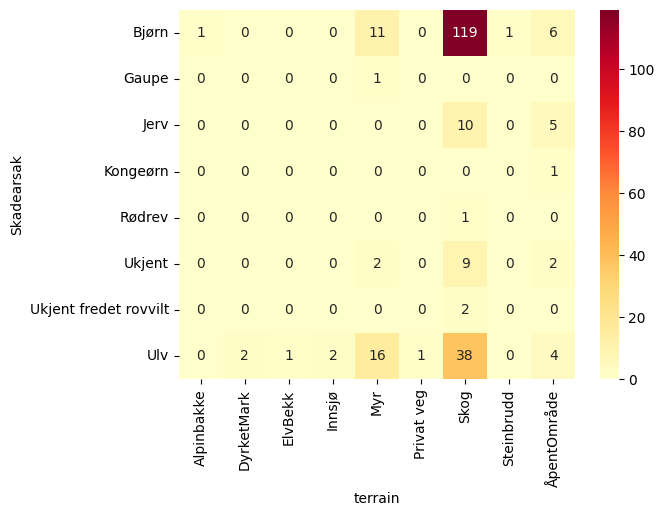

In [60]:
import sys
sys.path.append('../')
from features.Altitude import runner, add_new_column
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print(df['altitude'].mean())
print(df['altitude'].std())

print(df['terrain'].value_counts())


# Create a pivot table that counts the number of attacks by predator_type and terrain
pivot = pd.pivot_table(df, values='Skadedato_fra', index='Skadearsak', columns='terrain', aggfunc=len, fill_value=0)

# Create the heatmap using seaborn
sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='g')


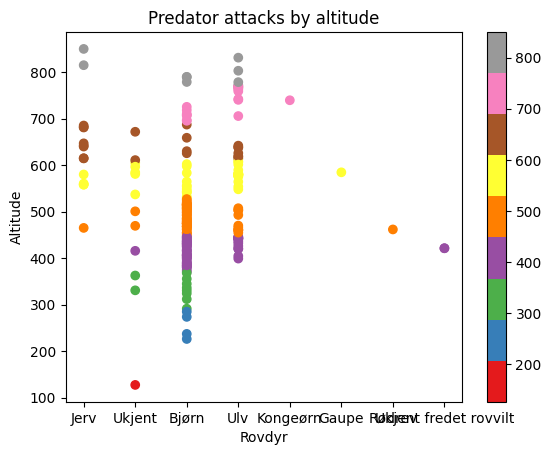

In [61]:
# create a scatter plot with altitude on y-axis and latitude on x-axis
plt.scatter(df['Skadearsak'],df['altitude'], c=df['altitude'], cmap='Set1')

# set the axis labels and title
plt.xlabel('Rovdyr')
plt.ylabel('Altitude')
plt.title('Predator attacks by altitude')

# add a colorbar to show the predator types
cbar = plt.colorbar()

# show the plot
plt.show()

## Hvor mange angrep er det som varer 1 dag, 2 dager og 3 dager

In [4]:
df['Skadedato_fra'] = pd.to_datetime(df['Skadedato_fra']) # må konvertere for å regne ut days diff
df['Skadedato_til'] = pd.to_datetime(df['Skadedato_til'])

diff_days = (df['Skadedato_til'] - df['Skadedato_fra']) / np.timedelta64(1, 'D')

count = Counter(diff_days)
print(count)

d = {'num_days': [], 'occur': []}
for x in count: # for å legge til i en bar chart
    key = x
    value = count[key]
    d['num_days'].append(key)
    d['occur'].append(value)

fig = px.bar(d, x='num_days', y='occur')
fig.update_layout(
    xaxis_title="Dager i forskjell",
    yaxis_title="Antall",
)
fig.update_xaxes(
    dtick=1
)
fig.show()

Counter({1.0: 113, 0.0: 78, 2.0: 44})


# Hvordan oppfører sauene seg på angrepsdag

In [267]:
df2015 = pd.read_csv('../data/kaasa/kaasa_2015.csv')
df2016 = pd.read_csv('../data/kaasa/kaasa_2016.csv')
df2017 = pd.read_csv('../data/kaasa/kaasa_2017.csv')
df2018 = pd.read_csv('../data/kaasa/kaasa_2018.csv')
df2019 = pd.read_csv('../data/kaasa/kaasa_2019.csv')
df2020 = pd.read_csv('../data/kaasa/kaasa_2020.csv')
df2021 = pd.read_csv('../data/kaasa/kaasa_2021.csv')

attack_data = pd.read_csv('../data/rovbase/rovviltskader.csv')

df = pd.concat([df2015, df2016, df2017, df2018, df2019, df2020, df2021], ignore_index=True)

In [268]:
from CloseToAttack import calculate_distance
from datetime import timedelta


# Create flock that is nearby an attack, return list of individuals in the flock
def create_flock(sheep_data, attack):

    # Get attack start and end date
    attack_start_date = attack['Skadedato_fra'].date()
    attack_end_date = attack['Skadedato_til'].date()

    # Only sheep in an attack will be in a flock nearby an attack
    sheep_data = sheep_data[sheep_data['attack'] == 1]
    
    # Each index corresponds to a row in the sheep data where date is within the attack dates
    sheep_indexes = sheep_data.loc[(attack_start_date <= sheep_data['date']) & (sheep_data['date'] <= attack_end_date)].index

    flock = [] # the flock nearby the attack

    for sheep in sheep_indexes:
        # Get latitude and longitude for sheep and attack
        sheep_lat = sheep_data.at[sheep, 'latitude']
        sheep_long = sheep_data.at[sheep, 'longitude']
        attack_lat = attack['latitude']
        attack_long = attack['longitude']

        # Calculate the distance from the sheep to the attack
        distance_to_attack = calculate_distance(sheep_lat, sheep_long, attack_lat, attack_long)
        
        if distance_to_attack <= 1500: # The sheep is nearby the attack
            ind = sheep_data.at[sheep, 'individual']
            if ind not in flock:
                flock.append(ind)

    return flock

In [269]:

# Return empty dataframe with feature-specific dataframe
def create_empty_mean_std_df(feature):
    mean = 'mean_{f}'.format(f=feature)
    std = 'std_{f}'.format(f=feature)
    bmean = 'before_mean_{f}'.format(f=feature)
    bstd = 'before_std_{f}'.format(f=feature)
    amean = 'after_mean_{f}'.format(f=feature)
    astd = 'after_std_{f}'.format(f=feature)

    # id = rovbaseid, num_ind = number of individs in that attack-flock
    df = pd.DataFrame(columns=['id', 'num_ind', mean, std, bmean, bstd, amean, astd])  
    return df 
    
# Return a list with all the values for means and std day before, during, and after attack based on feature-param
def get_mean_std_values(sheep_data, flock, attack, feature):    
    attack_start_date = attack['Skadedato_fra'].date()
    attack_end_date = attack['Skadedato_til'].date()

    day_before = attack_start_date - timedelta(days=1)
    day_after = attack_end_date + timedelta(days=1)
    
    on_attack_feature = pd.Series(dtype='int64')
    before_feature = pd.Series(dtype='int64')
    after_feature = pd.Series(dtype='int64')

    for ind in flock: # Loop through to get the feature from every sheep in the flock before and after attack
        on_attack = sheep_data.loc[(attack_start_date <= sheep_data['date']) & (sheep_data['date'] <= attack_end_date) & (sheep_data['individual'] == ind)]
        before = sheep_data.loc[(sheep_data['date'] == day_before) & (sheep_data['individual'] == ind)]
        after = sheep_data.loc[(sheep_data['date'] == day_after) & (sheep_data['individual'] == ind)]
        
        if len(on_attack) > 0:
            on_attack_feature = pd.concat([on_attack_feature, on_attack[feature]])
        if len(before) > 0:
            before_feature = pd.concat([before_feature, before[feature]])
        if len(after) > 0:
            after_feature = pd.concat([after_feature, after[feature]])
    
    # On attack date
    attack_mean = on_attack_feature.mean()
    attack_std = on_attack_feature.std()

    # On before date
    before_mean = before_feature.mean() 
    before_std = before_feature.std()
    
    # On after date
    after_mean = after_feature.mean() 
    after_std = after_feature.std()        

    rovId = attack['RovbaseID']  

    r = [rovId, len(flock), attack_mean, attack_std, before_mean, before_std, after_mean, after_std]
    return r

In [270]:
def create_mean_std_dfs(sheep_data, attack_data):
    attack_data['Skadedato_fra'] = pd.to_datetime(attack_data['Skadedato_fra'])
    attack_data['Skadedato_til'] = pd.to_datetime(attack_data['Skadedato_til'])

    sheep_data['date'] = pd.to_datetime(sheep_data['date_time']).dt.date # create new column with only date

    velocity_df = create_empty_mean_std_df('velocity')    
    angle_df = create_empty_mean_std_df('angle')
    altitude_df = create_empty_mean_std_df('altitude')

    for a in attack_data.index:
        attack = attack_data.iloc[a] # Get attack row
        flock = create_flock(sheep_data, attack)

        if len(flock) != 0:
            new_velocity_row = get_mean_std_values(sheep_data, flock, attack, 'velocity')
            new_angle_row = get_mean_std_values(sheep_data, flock, attack, 'angle')
            new_altitude_row = get_mean_std_values(sheep_data, flock, attack, 'altitude')
            velocity_df.loc[len(velocity_df.index)] = new_velocity_row
            angle_df.loc[len(angle_df.index)] = new_angle_row
            altitude_df.loc[len(altitude_df.index)] = new_altitude_row
    
    return velocity_df, angle_df, altitude_df 

In [271]:
def create_means(df_flokk, feature):
    before = 'before_{feature}'.format(feature=feature)
    after = 'after_{feature}'.format(feature=feature)

    org_mean = df_flokk[feature].mean()
    before_mean = df_flokk[before].mean()
    after_mean = df_flokk[after].mean()
    return [before_mean, org_mean, after_mean]

def create_stdev(df_flokk, feature):
    before = 'before_{feature}'.format(feature=feature)
    after = 'after_{feature}'.format(feature=feature)

    org_stdev = df_flokk[feature].std()
    before_stdev = df_flokk[before].std()
    after_stdev = df_flokk[after].std()
    return [before_stdev, org_stdev, after_stdev]

def create_fig(list, year, feature, text):
    print(list)
    fig = px.bar(list, width=800, height=500, title='{text} {feature} for the day before, during and after attack for {year}'.format(text=text, feature=feature, year=year))
    fig.update_layout(
    xaxis_title="Dager",
    yaxis_title="{text} {feature}".format(text=text, feature=feature),
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1, 2],
        ticktext = ['før', 'angrepsdagen', 'etter']
        )
    )
    fig.show()


## For all data

In [232]:
velocity_df, angle_df, altitude_df = create_mean_std_dfs(sheep_data=df, attack_data=attack_data)

In [234]:
velocity_df = velocity_df.drop_duplicates(['num_ind', 'mean_velocity', 'std_velocity', 'before_mean_velocity', 'before_std_velocity', 'after_mean_velocity', 'after_std_velocity'], ignore_index=True)
angle_df = angle_df.drop_duplicates(['num_ind', 'mean_angle', 'std_angle', 'before_mean_angle', 'before_std_angle', 'after_mean_angle', 'after_std_angle'], ignore_index=True)
altitude_df = altitude_df.drop_duplicates(['num_ind',  'mean_altitude', 'std_altitude', 'before_mean_altitude', 'before_std_altitude', 'after_mean_altitude', 'after_std_altitude'], ignore_index=True)


In [236]:
list_velocity_means = create_means(velocity_df, 'mean_velocity')
list_angle_means = create_means(angle_df, 'mean_angle')
list_altitude_means = create_means(altitude_df, 'mean_altitude')

In [237]:
create_fig(list_velocity_means, '2015-2021', feature='velocity', text='Mean')
create_fig(list_angle_means, '2015-2021', feature='angle', text='Mean')
create_fig(list_altitude_means, '2015-2021', feature='altitude', text='Mean')

[101.96146981814468, 137.02926299591857, 121.96734708142509]


[99.91411088530978, 98.68032073570221, 101.96752979686512]


[385.35122264875696, 386.1287906811678, 392.34217422139704]


In [239]:

list_velocity_stdev = create_means(velocity_df, 'std_velocity')
list_angle_stdev = create_means(angle_df, 'std_angle')
list_altitude_stdev = create_means(altitude_df, 'std_altitude')

create_fig(list_velocity_stdev, '2015-2021', feature='velocity', text='Standard deviation')
create_fig(list_angle_stdev, '2015-2021', feature='angle', text='Standard deviation')
create_fig(list_altitude_stdev, '2015-2021', feature='altitude', text='Standard deviation')

[152.02133396920826, 275.25571945939487, 198.70648642988766]


[55.48251825781456, 57.02623408353123, 53.89227788682978]


[72.77666959357508, 64.20449953920262, 62.27093523558147]


## For each year

Tar bort 2015, 2019 og 2021 siden de ikke har noen rovdyrangrep.

In [ ]:
velocity2016, angle2016, altitude2016 = create_mean_std_dfs(sheep_data=df2016, attack_data=attack_data)
velocity2017, angle2017, altitude2017 = create_mean_std_dfs(sheep_data=df2017, attack_data=attack_data)
velocity2018, angle2018, altitude2018 = create_mean_std_dfs(sheep_data=df2018, attack_data=attack_data)
velocity2020, angle2020, altitude2020 = create_mean_std_dfs(sheep_data=df2020, attack_data=attack_data)

In [ ]:
list_means2016 = create_means(df_flokk=velocity2016)
list_means2017 = create_means(df_flokk=velocity2017)
list_means2018 = create_means(df_flokk=velocity2018)
list_means2020 = create_means(df_flokk=velocity2020)

create_fig(list_means2016, '2016', 'Mean')
create_fig(list_means2017, '2017', 'Mean')
create_fig(list_means2018, '2018', 'Mean')
create_fig(list_means2020, '2020', 'Mean')

In [ ]:
list_stdev2016 = create_stdev(df_flokk=velocity2016)
list_stdev2017 = create_stdev(df_flokk=velocity2017)
list_stdev2018 = create_stdev(df_flokk=velocity2018)
list_stdev2020 = create_stdev(df_flokk=velocity2020)

create_fig(list_stdev2016, '2016', 'Standard deviation')
create_fig(list_stdev2017, '2017', 'Standard deviation')
create_fig(list_stdev2018, '2018', 'Standard deviation')
create_fig(list_stdev2020, '2020', 'Standard deviation')

# Distanse mellom første og siste punkt 
Vi vil regne ut distansen mellom første og siste punkt for hver sau på den dagen det er angrep. Dette blir gjort på hver sau i en flokk, slik at vi får se hvor langt flokken har bevegeset seg fra start til slutt på dagen før angrep, angrepsdagen og dagen etter.

In [282]:

def create_mean_std_distance(sheep_data, attack_data):
    attack_data['Skadedato_fra'] = pd.to_datetime(attack_data['Skadedato_fra'])
    attack_data['Skadedato_til'] = pd.to_datetime(attack_data['Skadedato_til'])

    sheep_data['date'] = pd.to_datetime(sheep_data['date_time']).dt.date # create new column with only date

    df = create_empty_mean_std_df('distance')
    
    for a in attack_data.index:
        attack = attack_data.iloc[a] # Get attack row
        flock = create_flock(sheep_data, attack)

        attack_start_date = attack['Skadedato_fra'].date()
        attack_end_date = attack['Skadedato_til'].date()

        day_before = attack_start_date - timedelta(days=1)
        day_after = attack_end_date + timedelta(days=1)

        dists_attack = pd.Series(dtype='int64')
        dists_before = pd.Series(dtype='int64')
        dists_after = pd.Series(dtype='int64')

        if len(flock) != 0: 

            for ind in flock: # Loop through to get the feature from every sheep in the flock before and after attack
                on_attack = sheep_data.loc[(attack_start_date <= sheep_data['date']) & (sheep_data['date'] <= attack_end_date) & (sheep_data['individual'] == ind)]
                before = sheep_data.loc[(sheep_data['date'] == day_before) & (sheep_data['individual'] == ind)]
                after = sheep_data.loc[(sheep_data['date'] == day_after) & (sheep_data['individual'] == ind)]

                dist_on_attack = get_dist_between_first_last_row(on_attack) if len(on_attack) > 0 else pd.Series(dtype='int64')
                dist_before = get_dist_between_first_last_row(before) if len(before) > 0 else pd.Series(dtype='int64')
                dist_after = get_dist_between_first_last_row(after) if len(after) > 0 else pd.Series(dtype='int64')
                
                dists_attack = pd.concat([dists_attack, dist_on_attack])
                dists_before = pd.concat([dists_before, dist_before])
                dists_after = pd.concat([dists_after, dist_after])
        
        
            attack_mean = dists_attack.mean()
            attack_std = dists_attack.std()

            # On before date
            before_mean = dists_before.mean() 
            before_std = dists_before.std()
            
            # On after date
            after_mean = dists_after.mean() 
            after_std = dists_after.std()  

            rovId = attack_data.at[a, 'RovbaseID']

            df.loc[len(df.index)] = [rovId, len(flock), attack_mean, attack_std, before_mean, before_std, after_mean, after_std]

    return df
        
def get_dist_between_first_last_row(df):
    first_date = df.iloc[0]
    last_date = df.iloc[-1]
    first_lat = first_date['latitude']
    first_long = first_date['longitude']
    last_lat = last_date['latitude']
    last_long = last_date['longitude']
    
    dist = calculate_distance(first_lat, first_long, last_lat, last_long)

    return pd.Series([dist])

In [283]:
distance_df = create_mean_std_distance(sheep_data=df, attack_data=attack_data)
distance_df = distance_df.drop_duplicates(['num_ind',  'mean_distance', 'std_distance', 'before_mean_distance', 'before_std_distance', 'after_mean_distance', 'after_std_distance'], ignore_index=True)
distance_df

,id,num_ind,mean_distance,std_distance,before_mean_distance,before_std_distance,after_mean_distance,after_std_distance
0,K469949,21,951.021595,1164.649786,1076.912777,937.892256,506.253508,881.663344
1,K469990,51,666.252954,558.747151,492.355108,546.031614,474.513178,463.948610
2,K470128,6,486.558574,289.937446,792.791868,692.686395,1381.219977,2033.055916
3,K470124,12,1982.861982,1840.783710,778.375029,509.491102,1164.022375,1614.353464
4,K470210,11,2104.563063,2134.810128,2376.358855,3582.372407,1310.867592,1313.840492
5,K470432,2,849.586642,236.360579,150.281606,15.971424,2909.865408,148.986211
6,K470434,22,935.290941,752.021219,684.347073,689.296838,855.342823,1057.544697
7,K470689,6,383.091130,364.731607,673.378399,762.172040,963.926920,1149.203728
8,K470687,4,1995.144759,567.579195,539.868855,320.923220,1081.038072,378.783095
9,K478267,1,3877.608120,NaN,1259.261646,NaN,645.353636,NaN


In [285]:
list_distance_mean = create_means(distance_df, 'mean_distance')
create_fig(list_distance_mean, '2015-2021', feature='distance', text='Mean')

[1038.9873998048906, 1149.710078748764, 1125.2174612426372]


In [287]:
list_distance_std = create_means(distance_df, 'std_distance')
create_fig(list_distance_std, '2015-2021', feature='distance', text='Standard deviation')

[924.2091985437489, 946.4790991684637, 725.2053056639909]
